# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
!pip install torchinfo

In [2]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [3]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 99090294.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23353710.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27066902.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3613529.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Визуализируйте несколько картинок с соответствующими метками из датасета.

Text(0.5, 1.0, 'Type of image for train dataset 965  class: 6')

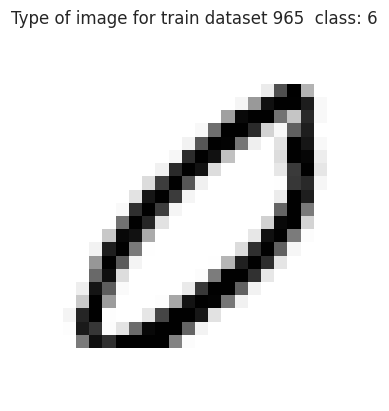

In [8]:
rand_idx = np.random.randint(low=0, high=len(train_dataset))
plt.imshow(train_dataset[rand_idx][0].permute([1, 2, 0]), cmap="Greys")
plt.axis("off")
plt.title(
    "Type of image for train dataset "
    + str(rand_idx)
    + "  class: "
    + str(val_dataset[rand_idx][1])
)

Text(0.5, 1.0, 'Type of image for validation dataset 8249  class: 8')

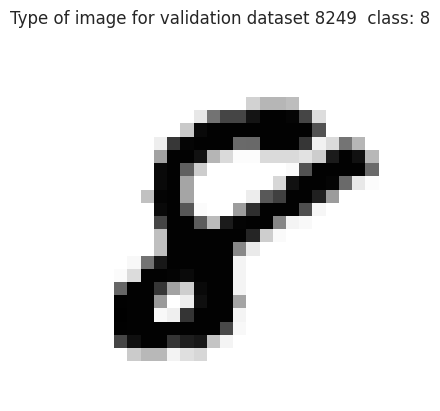

In [9]:
rand_idx = np.random.randint(low=0, high=len(val_dataset))
plt.imshow(val_dataset[rand_idx][0].permute([1, 2, 0]), cmap="Greys")
plt.axis("off")
plt.title(
    "Type of image for validation dataset "
    + str(rand_idx)
    + "  class: "
    + str(val_dataset[rand_idx][1])
)

Создайте генераторы батчей.

In [11]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [12]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )

In [13]:
def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)

In [14]:
def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc

In [15]:
def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [41]:
simple_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [42]:
summary(simple_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters())


history_cnn = train(
    simple_cnn, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_cnn.state_dict(), "simple_cnn.pth")

Epoch 40 of 40 took 10.525 s
  training loss: 	0.000001
  validation loss: 	0.044473
  training accuracy: 			100.00 %
  validation accuracy: 			99.30 %


In [20]:
simplified_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [21]:
summary(simplified_cnn1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 256]                  1,384,704
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 1,387,594
Trainable params: 1,387,594
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.55
Estimated Total Size (MB): 5.73

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simplified_cnn1.parameters())


simplified_cnn_1_conv_layer_2_kernel_sz_hist = train(
    simplified_cnn1, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(
    simplified_cnn1.state_dict(), "simplified_cnn_1_conv_layer_2_kernel_sz.pth"
)

Epoch 40 of 40 took 9.484 s
  training loss: 	0.000000
  validation loss: 	0.085595
  training accuracy: 			100.00 %
  validation accuracy: 			98.86 %


In [23]:
simplified_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(4),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simplified_cnn2.parameters())


simplified_cnn_1_conv_layer_4_kernel_sz_hist = train(
    simplified_cnn2, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(
    simplified_cnn2.state_dict(), "simplified_cnn_1_conv_layer_4_kernel_sz.pth"
)

Epoch 40 of 40 took 9.323 s
  training loss: 	0.000022
  validation loss: 	0.043711
  training accuracy: 			100.00 %
  validation accuracy: 			99.08 %


In [25]:
summary(simplified_cnn2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 6, 6]             --
├─ReLU: 1-3                              [1, 32, 6, 6]             --
├─Flatten: 1-4                           [1, 1152]                 --
├─Linear: 1-5                            [1, 256]                  295,168
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 298,058
Trainable params: 298,058
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 1.19
Estimated Total Size (MB): 1.37

In [26]:
light_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(8),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=288, out_features=10),
).to(device)

In [27]:
summary(light_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 3, 3]             --
├─ReLU: 1-3                              [1, 32, 3, 3]             --
├─Flatten: 1-4                           [1, 288]                  --
├─Linear: 1-5                            [1, 10]                   2,890
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.01
Estimated Total Size (MB): 0.19

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(light_cnn.parameters())


light_cnn_hist = train(
    light_cnn, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(light_cnn.state_dict(), "light_cnn_hist.pth")

Epoch 40 of 40 took 8.870 s
  training loss: 	0.058489
  validation loss: 	0.071778
  training accuracy: 			98.13 %
  validation accuracy: 			97.66 %


In [29]:
heavy_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
).to(device)

In [30]:
summary(heavy_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 128, 3, 3]            73,856
├─MaxPool2d: 1-8                         [1, 128, 1, 1]            --
├─ReLU: 1-9                              [1, 128, 1, 1]            --
├─Flatten: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 64]                   8,256
├─ReLU: 1-12                             [1, 64]                   --
├─L

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(heavy_cnn.parameters())


heavy_cnn_hist = train(
    heavy_cnn, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(heavy_cnn.state_dict(), "heavy_cnn_hist.pth")

Epoch 40 of 40 took 10.223 s
  training loss: 	0.005938
  validation loss: 	0.082678
  training accuracy: 			99.81 %
  validation accuracy: 			98.71 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

In [67]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "green"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].set_ylim(0.985, 1)
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

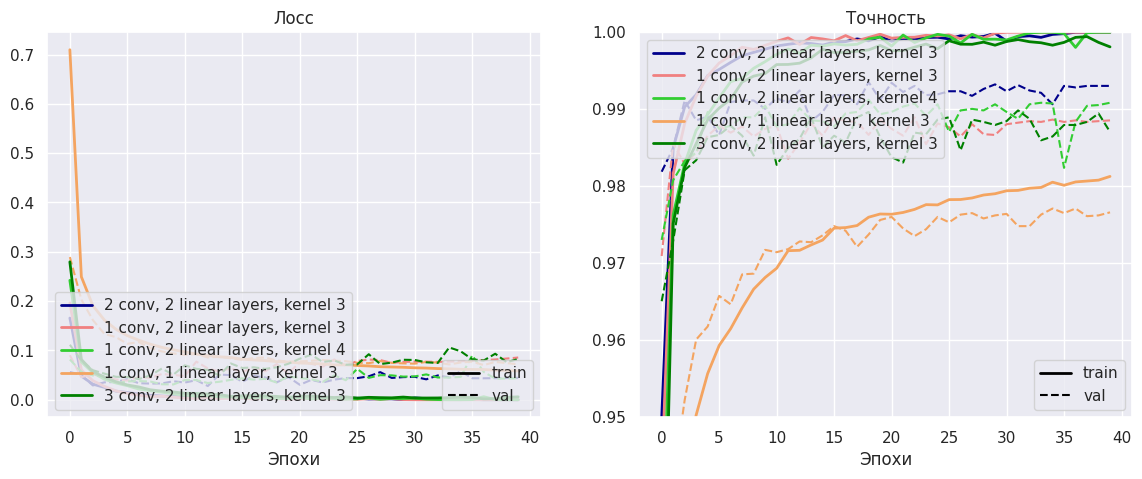

In [53]:
plot_histories(
    [
        history_cnn,
        simplified_cnn_1_conv_layer_2_kernel_sz_hist,
        simplified_cnn_1_conv_layer_4_kernel_sz_hist,
        light_cnn_hist,
        heavy_cnn_hist,
    ],
    [
        "2 conv, 2 linear layers, kernel 3",
        "1 conv, 2 linear layers, kernel 3",
        "1 conv, 2 linear layers, kernel 4",
        "1 conv, 1 linear layer, kernel 3",
        "3 conv, 2 linear layers, kernel 3",
    ],
)

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**
* При обучении на cpu время обучения быстро растёт при увеличении количества слоёв.
* При обучении на gpu время обучения при увеличении количества слоёв растёт крайне незначительно (вероятно, в связи с эффективным распараллеливанием вычислений на gpu).
* Совсем лёгкие модели, с одним свёрточным и одним линейным слоем показывают достаточно посредственные результаты при обучении, однако увеличение числа слоёв не является панацеей (самая тяжёлая модель не была лучшей).

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Заметим, что первая модель работает лучше всего


In [43]:
simple_cnn_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [44]:
summary(simple_cnn_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

In [54]:
simple_cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [55]:
summary(simple_cnn_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 9, 9]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 316,554
Trainable params: 316,554
Non-trainable params: 0
Total mult-adds (M): 4.63
Input size (MB): 0.00
Forward/backward pass 

In [56]:
simple_cnn_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [57]:
summary(simple_cnn_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 10, 10]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,754
Trainable params: 431,754
Non-trainable params: 0
Total mult-adds (M): 2.74
Input size (MB): 0.00
Forward/backward pass 

In [58]:
simple_cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [59]:
summary(simple_cnn_4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 317,066
Trainable params: 317,066
Non-trainable params: 0
Total mult-adds (M): 4.03
Input size (MB): 0.00
Forward/backward pass 

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_1.parameters())


simple_cnn_1_hist = train(
    simple_cnn_1, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_1.state_dict(), "simple_cnn_1_hist.pth")

Epoch 40 of 40 took 9.982 s
  training loss: 	0.000648
  validation loss: 	0.059505
  training accuracy: 			99.98 %
  validation accuracy: 			99.21 %


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_2.parameters())


simple_cnn_2_hist = train(
    simple_cnn_2, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_2.state_dict(), "simple_cnn_2_hist.pth")

Epoch 40 of 40 took 9.585 s
  training loss: 	0.000585
  validation loss: 	0.047789
  training accuracy: 			99.98 %
  validation accuracy: 			99.32 %


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_3.parameters())


simple_cnn_3_hist = train(
    simple_cnn_3, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_3.state_dict(), "simple_cnn_3_hist.pth")

Epoch 40 of 40 took 9.925 s
  training loss: 	0.002008
  validation loss: 	0.060848
  training accuracy: 			99.94 %
  validation accuracy: 			99.28 %


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_4.parameters())


simple_cnn_4_hist = train(
    simple_cnn_4, criterion, optimizer, train_batch_gen, val_batch_gen
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_4.state_dict(), "simple_cnn_4_hist.pth")

Epoch 40 of 40 took 9.736 s
  training loss: 	0.001339
  validation loss: 	0.063336
  training accuracy: 			99.96 %
  validation accuracy: 			99.09 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

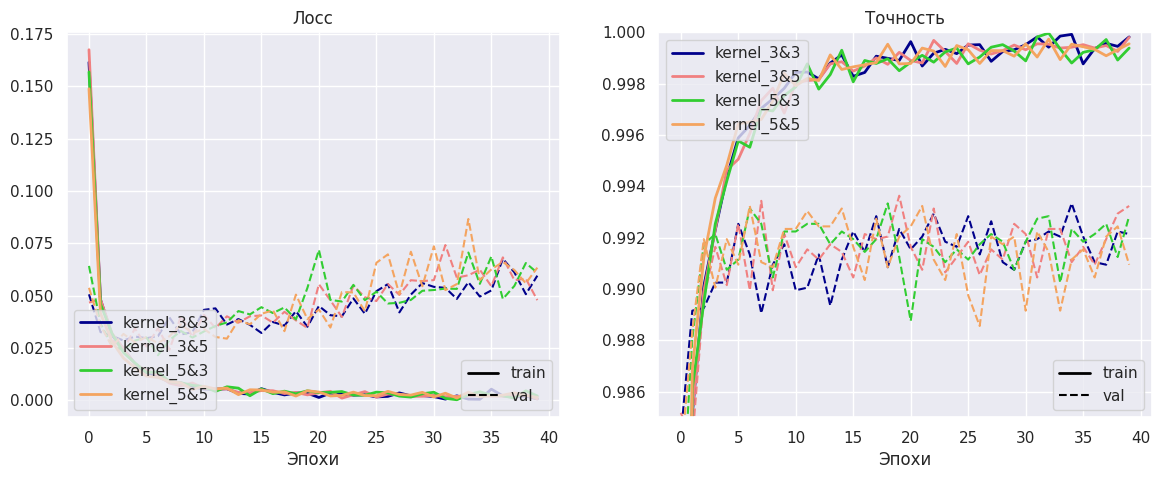

In [68]:
plot_histories(
    [
        simple_cnn_1_hist,
        simple_cnn_2_hist,
        simple_cnn_3_hist,
        simple_cnn_4_hist,
    ],
    ["kernel_3&3", "kernel_3&5", "kernel_5&3", "kernel_5&5"],
)

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**
* В случае простой задачи влияние размеров ядер на качество обучения незначительно, на gpu влияние размера ядер на время обучения опять же незначительно

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [ ]:
bst_model = simple_cnn_4

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [ ]:
val_batch = torch.utils.data.DataLoader(
    val_dataset, batch_size=len(val_dataset), shuffle=False
)

In [ ]:
integer_classes = [int(i) for i in classes]

In [ ]:
accuracy_for_classes = []
wrong_predictions = []
for X, y in val_batch:
    X = X.to(device)
    y = y.to(device)

    logits = bst_model(X)
    y_pred = logits.max(1)[1].detach()
    for num in integer_classes:
        total = len(y[y == num])
        true = len(y_pred[(y == num) & (y_pred == num)])
        wrong_predictions += list(
            zip(
                X[(y == num) & (y_pred != num)],
                y[(y == num) & (y_pred != num)],
                y_pred[(y == num) & (y_pred != num)],
            )
        )
        accuracy_for_classes.append([true / total, total])

In [ ]:
accuracy_for_classes

[[0.9979591836734694, 980],
 [1.0, 1135],
 [0.997093023255814, 1032],
 [0.995049504950495, 1010],
 [0.994908350305499, 982],
 [0.9910313901345291, 892],
 [0.9906054279749478, 958],
 [0.9883268482490273, 1028],
 [0.9948665297741273, 974],
 [0.9881070366699702, 1009]]

In [ ]:
for cls in integer_classes:
    print(
        f"Number: {cls}   Accuracy: {accuracy_for_classes[cls][0]:.4f}    Number of images: {accuracy_for_classes[cls][1]}"
    )

Number: 0   Accuracy: 0.9980    Number of images: 980
Number: 1   Accuracy: 1.0000    Number of images: 1135
Number: 2   Accuracy: 0.9971    Number of images: 1032
Number: 3   Accuracy: 0.9950    Number of images: 1010
Number: 4   Accuracy: 0.9949    Number of images: 982
Number: 5   Accuracy: 0.9910    Number of images: 892
Number: 6   Accuracy: 0.9906    Number of images: 958
Number: 7   Accuracy: 0.9883    Number of images: 1028
Number: 8   Accuracy: 0.9949    Number of images: 974
Number: 9   Accuracy: 0.9881    Number of images: 1009


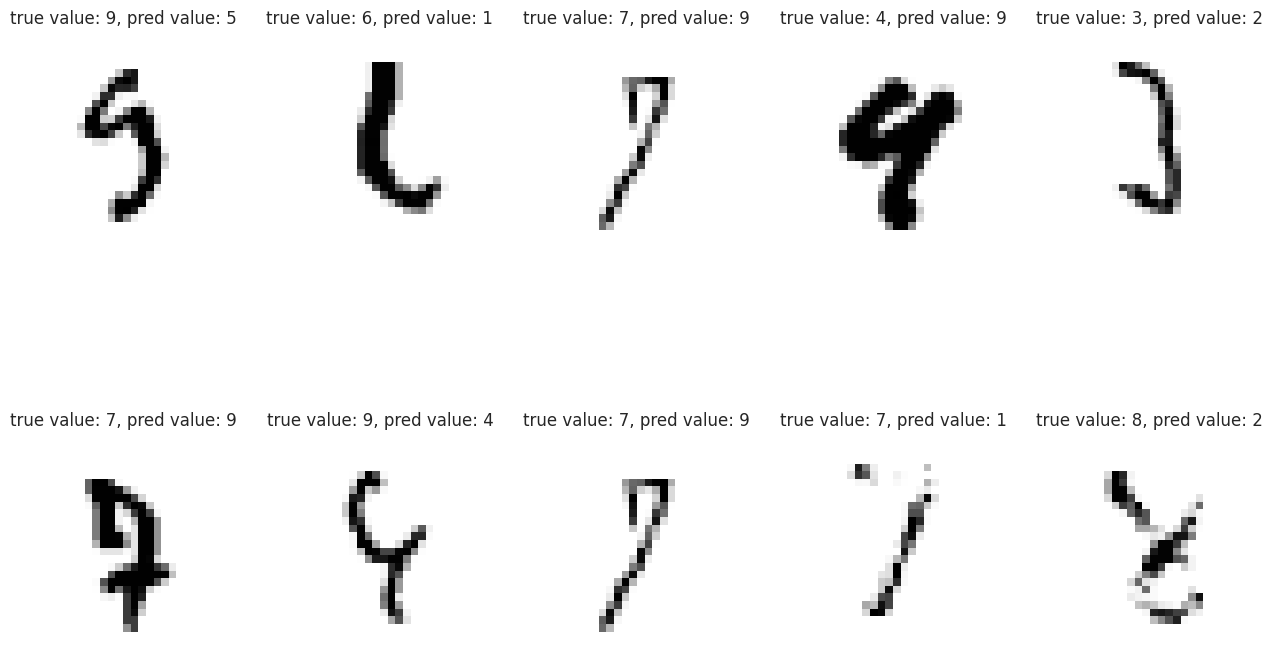

In [ ]:
idx = np.random.randint(0, len(wrong_predictions), 10)
plt.figure(figsize=(16, 20))
for i, index in enumerate(idx):
    plt.subplot(4, 5, i + 1)
    plt.imshow(wrong_predictions[index][0].cpu().permute(1, 2, 0), cmap="Greys")
    plt.title(
        f"true value: {wrong_predictions[index][1]}, pred value: {wrong_predictions[index][2]}"
    )
    plt.axis("off")

**Ответ:**

Неверно классифицированные картинки представляют собой отвратительно написанные цифры, я не уверен, что даже живой человек будет способен их классифицировать.

**Вывод по всей задаче:**
* Даже достаточно простые нейронные сети, состоящие из двух свёрточных и двух линейных слоёв хорошо справляются с классификацией простых изображений, таких как рукописные цифры (состоящих, фактически, из наклонных, горизонтальных и вертикальных черт).

* Даже при обучении таких достаточно простых, в сущности, моделей, крайне важно использование gpu (она позволяет на порядки ускорить обучение).

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from google.colab import drive

sns.set(palette="Set2")

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [ ]:
from NST import *

In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

In [ ]:
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.5MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=145915396096.0000, content_loss=      0.0000, style loss=145908945000.0000, tv loss=6453278.0000
L-BFGS | iteration: 100, total loss=1547015936.0000, content_loss=589413281.2500, style loss=942250722.6562, tv loss=15351828.0000
L-BFGS | iteration: 200, total loss=1085177600.0000, content_loss=553532080.0781, style loss=515332207.0312, tv loss=16313308.0000
L-BFGS | iteration: 300, total loss=963772864.0000, content_loss=533531542.9688, style loss=413678525.3906, tv loss=16562780.0000
L-BFGS | iteration: 400, total loss=909021696.0000, content_loss=521040917.9688, style loss=371455312.5000, tv loss=16525472.0000
L-BFGS | iteration: 500, total loss=879864512.0000, content_loss=513713769.5312, style loss=349733291.0156, tv loss=16417461.0000
L-BFGS | iteration: 600, total loss=860782784.0000, content_loss=508408837.8906, style loss=336073095.7031, tv loss=16300877.0000
L-BFGS | iteration: 700, total loss=847710

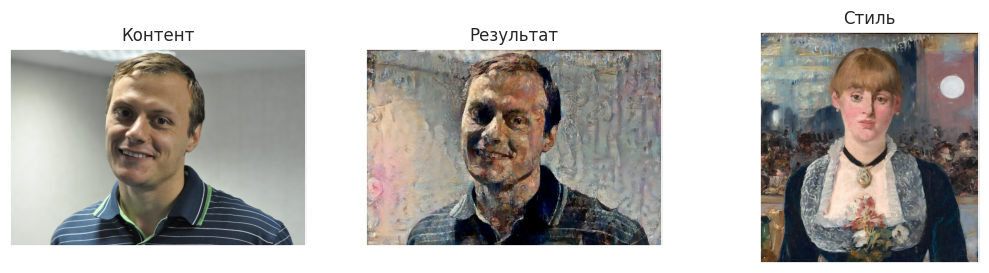

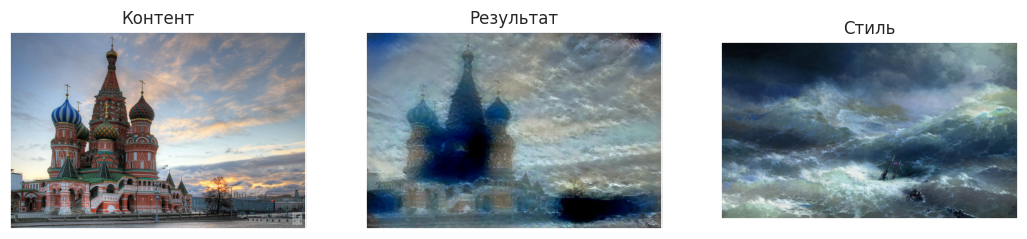

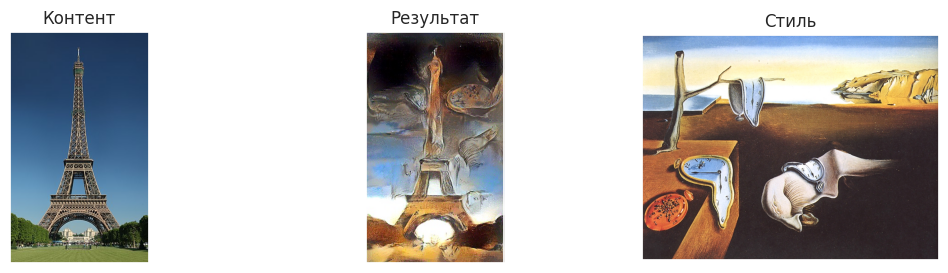

In [ ]:
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00


In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt1 = "Alexander Gasnikov in style of Manet"
prompt2 = "Saint Basil's Cathedral in style of Ivan Aivazovsky"
prompt3 = "Eiffel Tower in style of Salvador Dalí"

  0%|          | 0/50 [00:00<?, ?it/s]

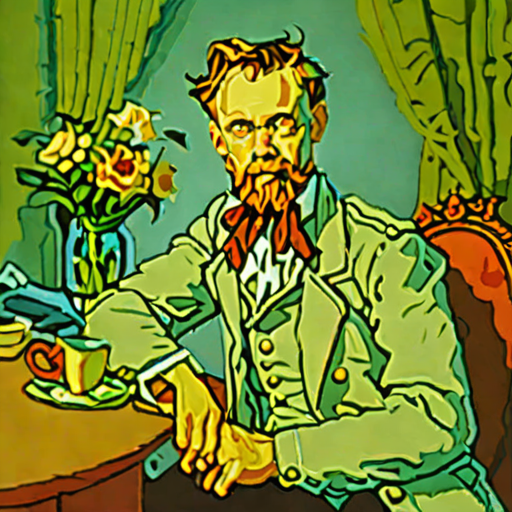

In [ ]:
image = pipe(prompt=prompt1, num_inference_steps=50, guidance_scale=0.0).images[
    0
]
image

  0%|          | 0/50 [00:00<?, ?it/s]

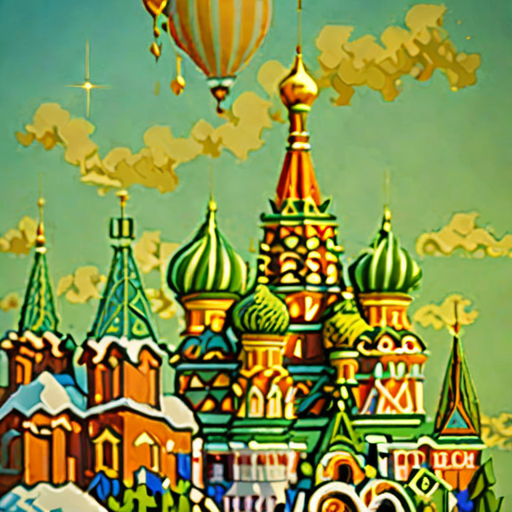

In [ ]:
image = pipe(prompt=prompt2, num_inference_steps=50, guidance_scale=0.0).images[
    0
]
image

  0%|          | 0/40 [00:00<?, ?it/s]

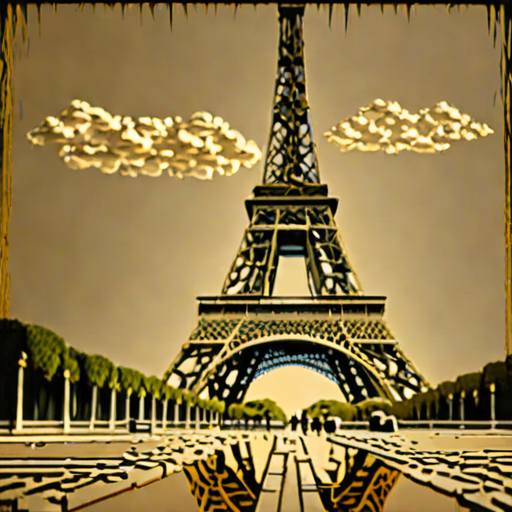

In [ ]:
image = pipe(prompt=prompt3, num_inference_steps=40, guidance_scale=0.0).images[
    0
]
image

**Вывод:**
* Можно видеть, что первая нейросеть, обрабатывающая изображение под конкретный стиль, работает достаточно эффективно
* Нейросеть, генерирующая изображение по тексту выдаёт посредственный результат: вероятно, это связано с использованием специфических изображений, которых не было в обучающей выборке данной модели.
* Тяжёлые нейронные сети, работающие с изображениями, практически невозможно обучать без gpu (время обучения будет поистине заоблачным)